In [1]:
%load_ext autoreload
%autoreload 2

### data loading and preparation

In [2]:
import concord as ccd
import scanpy as sc
import torch
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')
import time
from pathlib import Path
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
seed = 0

In [3]:
proj_name = "hypomap_QZ"
file_name = "hypomap_QZ"
file_suffix = time.strftime('%b%d-%H%M')
seed = 0

save_dir = Path(f"../save/{proj_name}")
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = Path(f"../data/{proj_name}")
data_dir.mkdir(parents=True, exist_ok=True)


In [4]:
adata = sc.read_h5ad(data_dir / f"HypoMap_Steuernagel_preprocessed_HVG.h5ad")

In [5]:
adata.shape

(384925, 5000)

### Create jobs

In [6]:
concord_args = {
        'save_dir': '../'+str(save_dir) # Directory to save the model and results
    }

In [8]:
adata.obs['Batch_ID'].value_counts()

Batch_ID
Anderson10x_batch_1         60756
Kim10x_batch_1              40599
Rupp10x_batch_1             33502
Dowsett10xnuc_batch_1       24759
wen10x_batch_1              17483
wenDropseq_batch_1          16181
CampbellDropseq_batch_1     15641
Moffit10x_batch_3           14958
Morris10x_batch_1           13660
ChenDropseq_batch_1         13329
Morris10x_batch_3           11798
Mousebrainorg10x_batch_2    11747
Dowsett10xnuc_batch_2       11186
Mousebrainorg10x_batch_1     9674
RossiDropseq_batch_1         9292
Moffit10x_batch_2            8892
Affinati10x_batch_1          8477
Mickelsen10x_batch_1         8441
Affinati10x_batch_4          8404
Flynn10x_batch_1             7489
kimDev10x_batch_1            6912
Affinati10x_batch_3          6056
Flynn10x_batch_2             5864
Morris10x_batch_2            5492
CampbellDropseq_batch_2      5248
Moffit10x_batch_1            4185
LeeDropseq_batch_1           2212
RomanovDev10x_batch_1        2152
Affinati10x_batch_2           536
Name:

In [13]:
import subprocess, json
output_dir = "../jobs"
proj_folder = Path(output_dir) / f"benchmark_{proj_name}"   # ../jobs/benchmark_<proj>
proj_folder.mkdir(exist_ok=True)      
#py_methods = ["concord_hcl", "concord_knn"]
py_methods = ['concord_knn', 'concord_hcl']
output_dir = '../jobs'
device = 'auto'
conda_env = 'concord'
batch_key = 'Batch_ID'
state_key = 'None'
latent_dim = '50'  # Adjust as needed, but should match the encoder_dims in concord_args
subprocess.run([
    "python", "./generate_py_jobs.py",
    "--proj_name", proj_name,
    "--adata_filename", "HypoMap_Steuernagel_preprocessed_HVG.h5ad",
    "--methods", *py_methods,
    "--batch_key", batch_key,
    "--state_key", state_key,
    "--latent_dim", latent_dim,
    "--output_dir", output_dir,
    "--device", device,
    "--conda_env", conda_env,
    "--runtime", "02:00:00",
    "--concord_kwargs", json.dumps(concord_args),
    "--verbose"
])


✅ Generated: benchmark_hypomap_QZ/benchmark_hypomap_QZ_concord_knn.py
✅ Generated: benchmark_hypomap_QZ/benchmark_hypomap_QZ_concord_knn.sh

✅ Generated: benchmark_hypomap_QZ/benchmark_hypomap_QZ_concord_hcl.py
✅ Generated: benchmark_hypomap_QZ/benchmark_hypomap_QZ_concord_hcl.sh



CompletedProcess(args=['python', './generate_py_jobs.py', '--proj_name', 'hypomap_QZ', '--adata_filename', 'HypoMap_Steuernagel_preprocessed_HVG.h5ad', '--methods', 'concord_knn', 'concord_hcl', '--batch_key', 'Batch_ID', '--state_key', 'None', '--latent_dim', '50', '--output_dir', '../jobs', '--device', 'auto', '--conda_env', 'concord', '--runtime', '02:00:00', '--concord_kwargs', '{"save_dir": "../../save/hypomap_QZ"}', '--verbose'], returncode=0)

In [14]:
# ------------------------------------------------------------------
# create submit_sequential_<proj>.sh  (runs each *.py job in order)
# ------------------------------------------------------------------
sequential_submit = proj_folder / f"submit_sequential_{proj_name}.sh"

sequential_template = """#!/bin/bash
set -euo pipefail
cd "$(dirname "$0")"           # work inside this folder
shopt -s nullglob              # empty globs expand to nothing

for job in *.py; do
  base=${job%.py}              # strip the .py suffix
  log="${base}.log"            # e.g. train_model.py → train_model.log

  echo ">>> $job   $(date)" | tee -a "$log"
  if python "$job" >>"$log" 2>&1; then
      echo ">>> finished OK"   | tee -a "$log"
  else
      echo ">>> FAILED"        | tee -a "$log"
  fi
done
"""

sequential_submit.write_text(sequential_template)
sequential_submit.chmod(0o755)
print(f"📌  Run “{sequential_submit}” to queue jobs sequentially.")


📌  Run “../jobs/benchmark_hypomap_QZ/submit_sequential_hypomap_QZ.sh” to queue jobs sequentially.


### Collect results

In [15]:
# Delete existing latents in adata.obsm
for key in list(adata.obsm.keys()):
    del adata.obsm[key]

In [16]:
methods = ["concord_hcl", "concord_knn"]
from benchmark_utils import add_embeddings
# ---------------------------- Add Embeddings ----------------------------
adata = add_embeddings(adata, proj_name=proj_name, methods=methods)

✅ obsm['concord_hcl'] loaded
✅ obsm['concord_knn'] loaded


In [18]:
for method in methods:
    if f"{method}_UMAP" in adata.obsm:
        print(f"[⚠️ Warning] obsm['{method}_UMAP'] already exists, skipping UMAP computation")
    else:
        print(f"Computing 2D UMAP for {method}...")
        ccd.ul.run_umap(adata, source_key=f"{method}", result_key=f"{method}_UMAP", n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
        print(f"✅ obsm['{method}_UMAP'] computed")

ccd.ul.save_obsm_to_hdf5(adata, save_dir / f"obsm_{file_suffix}.h5")
print(f"✅ Embeddings saved to {save_dir / f'obsm_{file_suffix}.h5'}")
final_path = data_dir / f"{file_name}_final.h5ad"
adata.write_h5ad(final_path)
print(f"✅ Final AnnData saved to: {final_path}")

Computing 2D UMAP for concord_hcl...


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Concord - INFO - UMAP embedding stored in adata.obsm['concord_hcl_UMAP']
✅ obsm['concord_hcl_UMAP'] computed
Computing 2D UMAP for concord_knn...
Concord - INFO - UMAP embedding stored in adata.obsm['concord_knn_UMAP']
✅ obsm['concord_knn_UMAP'] computed
✅ Embeddings saved to ../save/hypomap_QZ/obsm_Jul02-1432.h5
✅ Final AnnData saved to: ../data/hypomap_QZ/hypomap_QZ_final.h5ad


✅ Benchmark summary saved to: ../save/hypomap_QZ/benchmark_summary_Jul02-1432.tsv


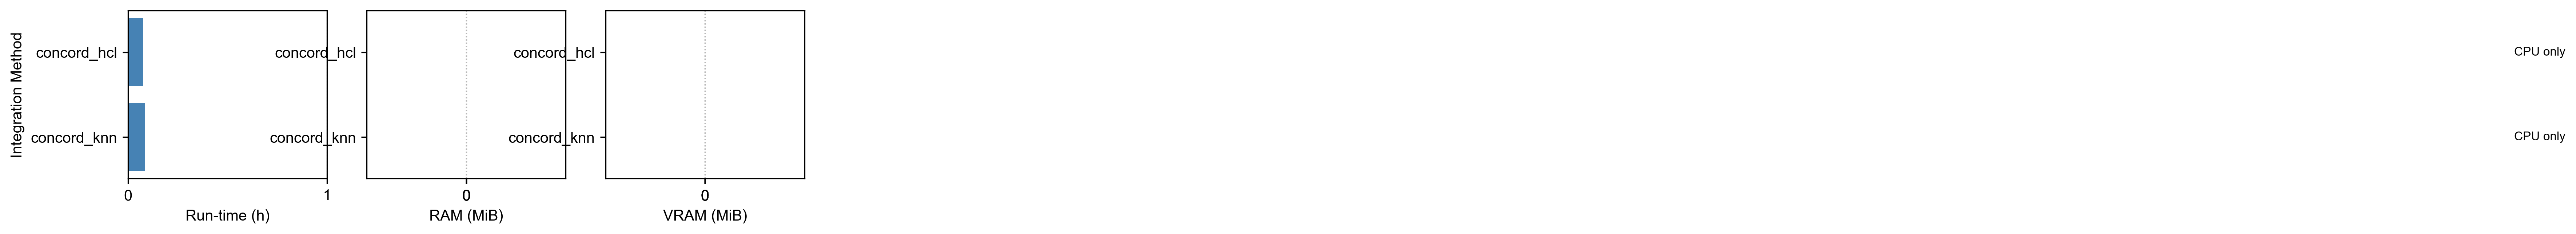

In [17]:
from benchmark_utils import collect_benchmark_logs
bench_df = collect_benchmark_logs(file_name, methods)
# Save the benchmark results
bench_df.to_csv(save_dir / f"benchmark_summary_{file_suffix}.tsv", sep="\t", index=False)
print(f"✅ Benchmark summary saved to: {save_dir / f'benchmark_summary_{file_suffix}.tsv'}")
# Plot benchmark results
from benchmark_utils import plot_benchmark_performance
import matplotlib.pyplot as plt
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}
with plt.rc_context(rc=custom_rc):
    plot_benchmark_performance(bench_df, figsize=(8,2), dpi=300, save_path = save_dir / f"benchmark_plot_{file_suffix}.pdf")


In [ ]:
adata.obs['Batch_ID']

,SRA_ID,Sample_ID,organism_ontology_term_id,donor_id,development_stage_ontology_term_id,sex_ontology_term_id,self_reported_ethnicity_ontology_term_id,disease_ontology_term_id,tissue_ontology_term_id,cell_type_ontology_term_id,...,development_stage,observation_joinid,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes
AAACCCAAGGGTGAAA-1_SRR14252354,SRR14252354,Affinati10x_Sample_A,NCBITaxon:10090,pooled,MmusDv:0000062,PATO:0000383,na,PATO:0000461,UBERON:0001898,CL:0000540,...,2-month-old stage,^J<ClZ-+1g,1760,7.473637,3310,8.105006,37.009063,41.570997,48.157100,61.933535
AAACCCACAGCACACC-1_SRR14252354,SRR14252354,Affinati10x_Sample_A,NCBITaxon:10090,pooled,MmusDv:0000062,PATO:0000383,na,PATO:0000461,UBERON:0001898,CL:0000540,...,2-month-old stage,;l|Z|wKd;$,963,6.871091,1209,7.098376,16.625310,24.896609,36.889992,61.703888
AAACCCATCCCGAAAT-1_SRR14252354,SRR14252354,Affinati10x_Sample_A,NCBITaxon:10090,pooled,MmusDv:0000062,PATO:0000383,na,PATO:0000461,UBERON:0001898,CL:0000540,...,2-month-old stage,xTr1#5{s5N,2163,7.679714,4045,8.305484,32.756489,37.181706,43.683560,58.516687
AAACGAAAGACCAGCA-1_SRR14252354,SRR14252354,Affinati10x_Sample_A,NCBITaxon:10090,pooled,MmusDv:0000062,PATO:0000383,na,PATO:0000461,UBERON:0001898,CL:0000540,...,2-month-old stage,d;NrKa=RPx,1976,7.589336,3154,8.056744,22.289157,27.393786,34.876347,53.202283
AAACGAAAGGTCCAGA-1_SRR14252354,SRR14252354,Affinati10x_Sample_A,NCBITaxon:10090,pooled,MmusDv:0000062,PATO:0000383,na,PATO:0000461,UBERON:0001898,CL:0000540,...,2-month-old stage,niurgY`fcf,1583,7.367709,2590,7.859799,29.961390,35.057915,42.779923,58.185328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTCACCCCCGAA_SRR7535555,SRR7535555,wenDropseq_SRR7535555,NCBITaxon:10090,pooled,MmusDv:0000062,PATO:0000384,na,PATO:0000461,UBERON:0001898,CL:0000540,...,2-month-old stage,4TMv!XVrj<,1226,7.112327,1714,7.447168,17.036173,24.504084,36.172695,57.642940
TTGTAGTTGAGT_SRR7535555,SRR7535555,wenDropseq_SRR7535555,NCBITaxon:10090,pooled,MmusDv:0000062,PATO:0000384,na,PATO:0000461,UBERON:0001898,CL:0000065,...,2-month-old stage,h?*^o!dRa|,1502,7.315218,2299,7.740664,19.269247,26.359287,36.494128,56.415833
TTTTCCACCCCT_SRR7535555,SRR7535555,wenDropseq_SRR7535555,NCBITaxon:10090,pooled,MmusDv:0000062,PATO:0000384,na,PATO:0000461,UBERON:0001898,CL:0000540,...,2-month-old stage,t8fCJr_<3F,3930,8.276649,9955,9.205931,23.987946,29.080864,36.454043,50.436966
GGTGAGGCGGTG_SRR7535555,SRR7535555,wenDropseq_SRR7535555,NCBITaxon:10090,pooled,MmusDv:0000062,PATO:0000384,na,PATO:0000461,UBERON:0001898,CL:0000540,...,2-month-old stage,%~&k)(rla!,785,6.666957,1010,6.918695,19.603960,29.504950,42.079208,71.782178


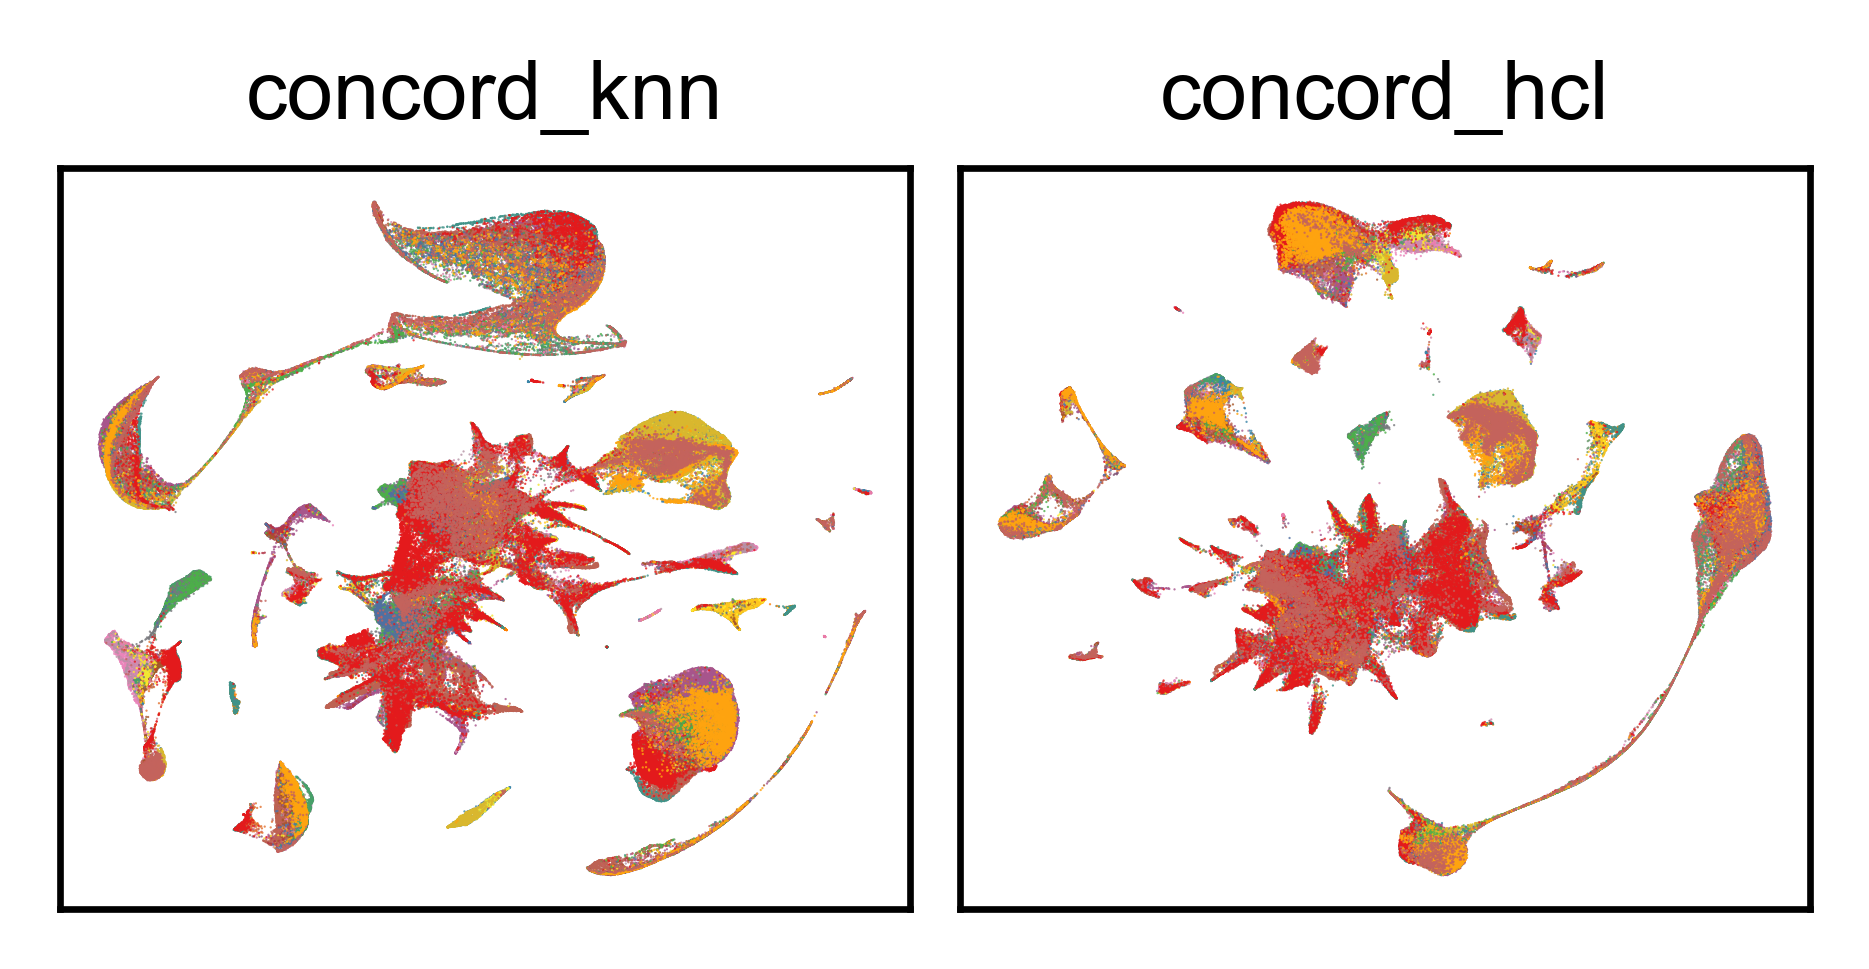

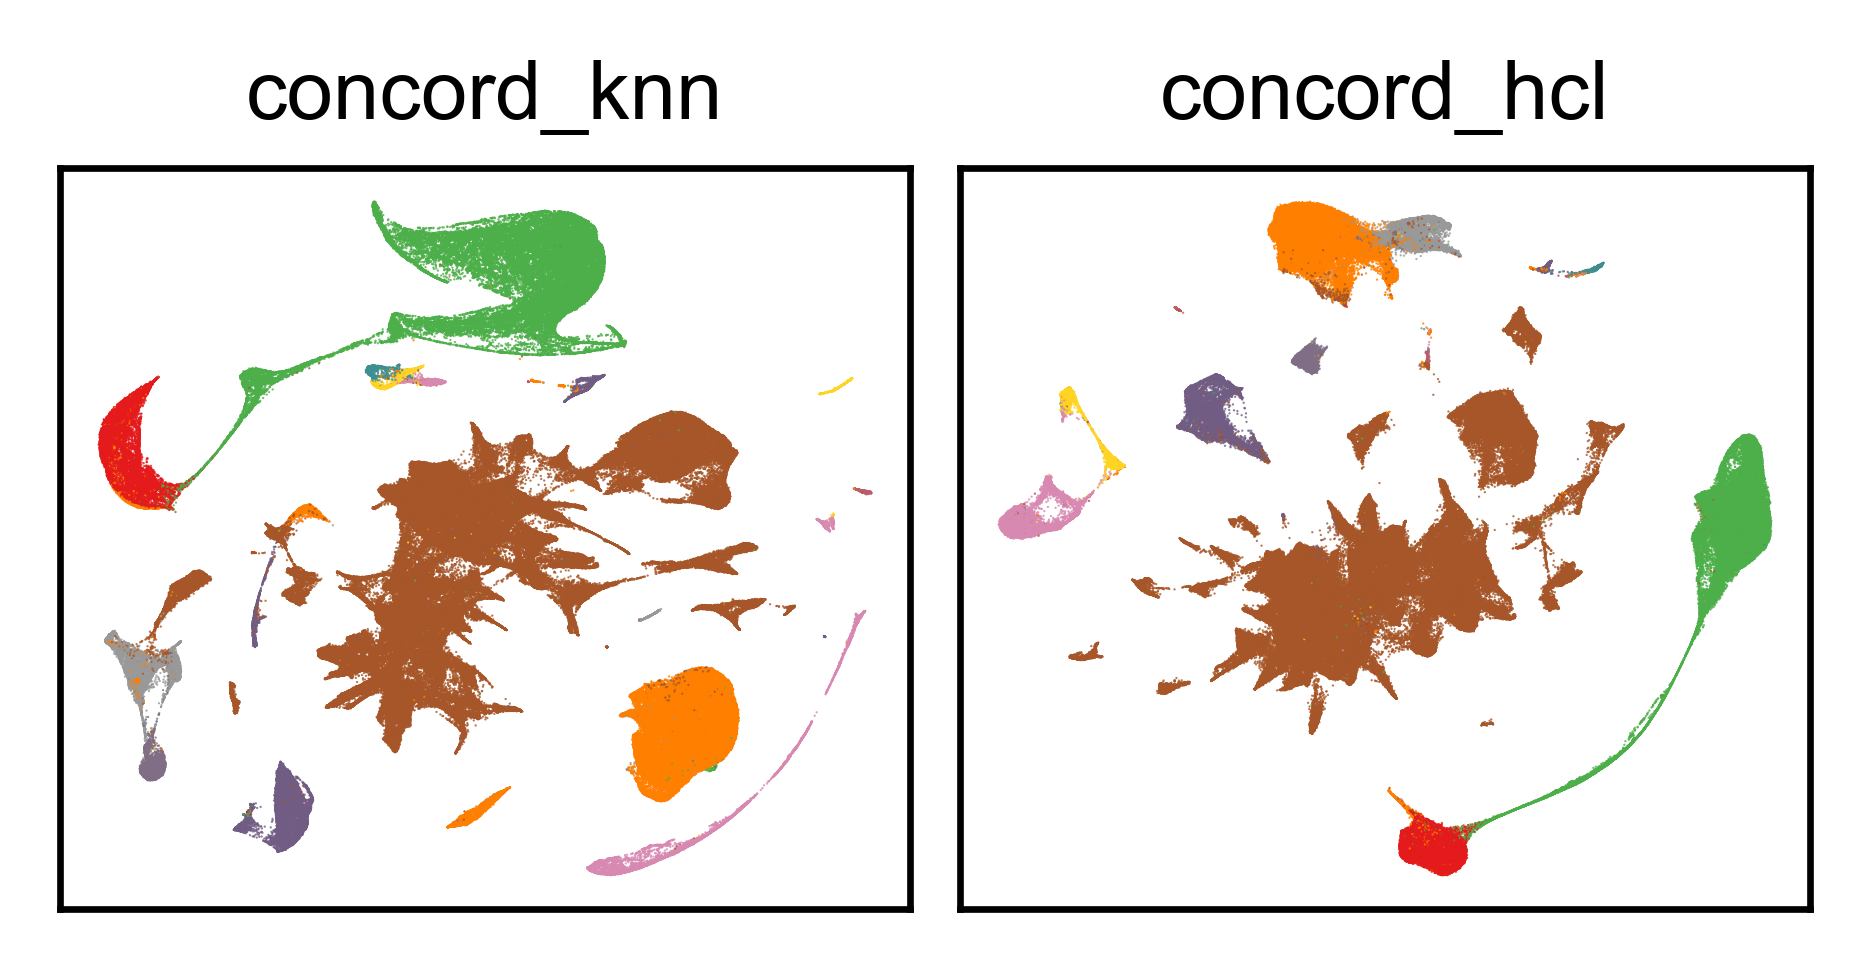

In [20]:
# plot everything
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams

# Set Arial as the default font
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

show_keys = py_methods
show_cols = ['Batch_ID', 'cell_type']
basis_types = ['UMAP']

font_size=10
point_size=.3
alpha=0.8
ncols = len(show_keys)
figsize=(ncols * 1.5,1.5)
nrows = int(np.ceil(len(show_keys) / ncols))
pal = {'donor_id': 'Set1',
       "author_cell_type": 'Paired',}

with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata,
        show_keys,
        color_bys=show_cols,
        basis_types=basis_types,
        pal=pal,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        figsize=figsize,
        ncols=ncols,
        seed=seed,
        save_dir=save_dir,
        file_suffix=file_suffix,
        dpi=600,
        save_format='svg'
    )


Detected task: classification
Detected task: classification
[KNN] detected task: classification
[KNN] detected task: classification


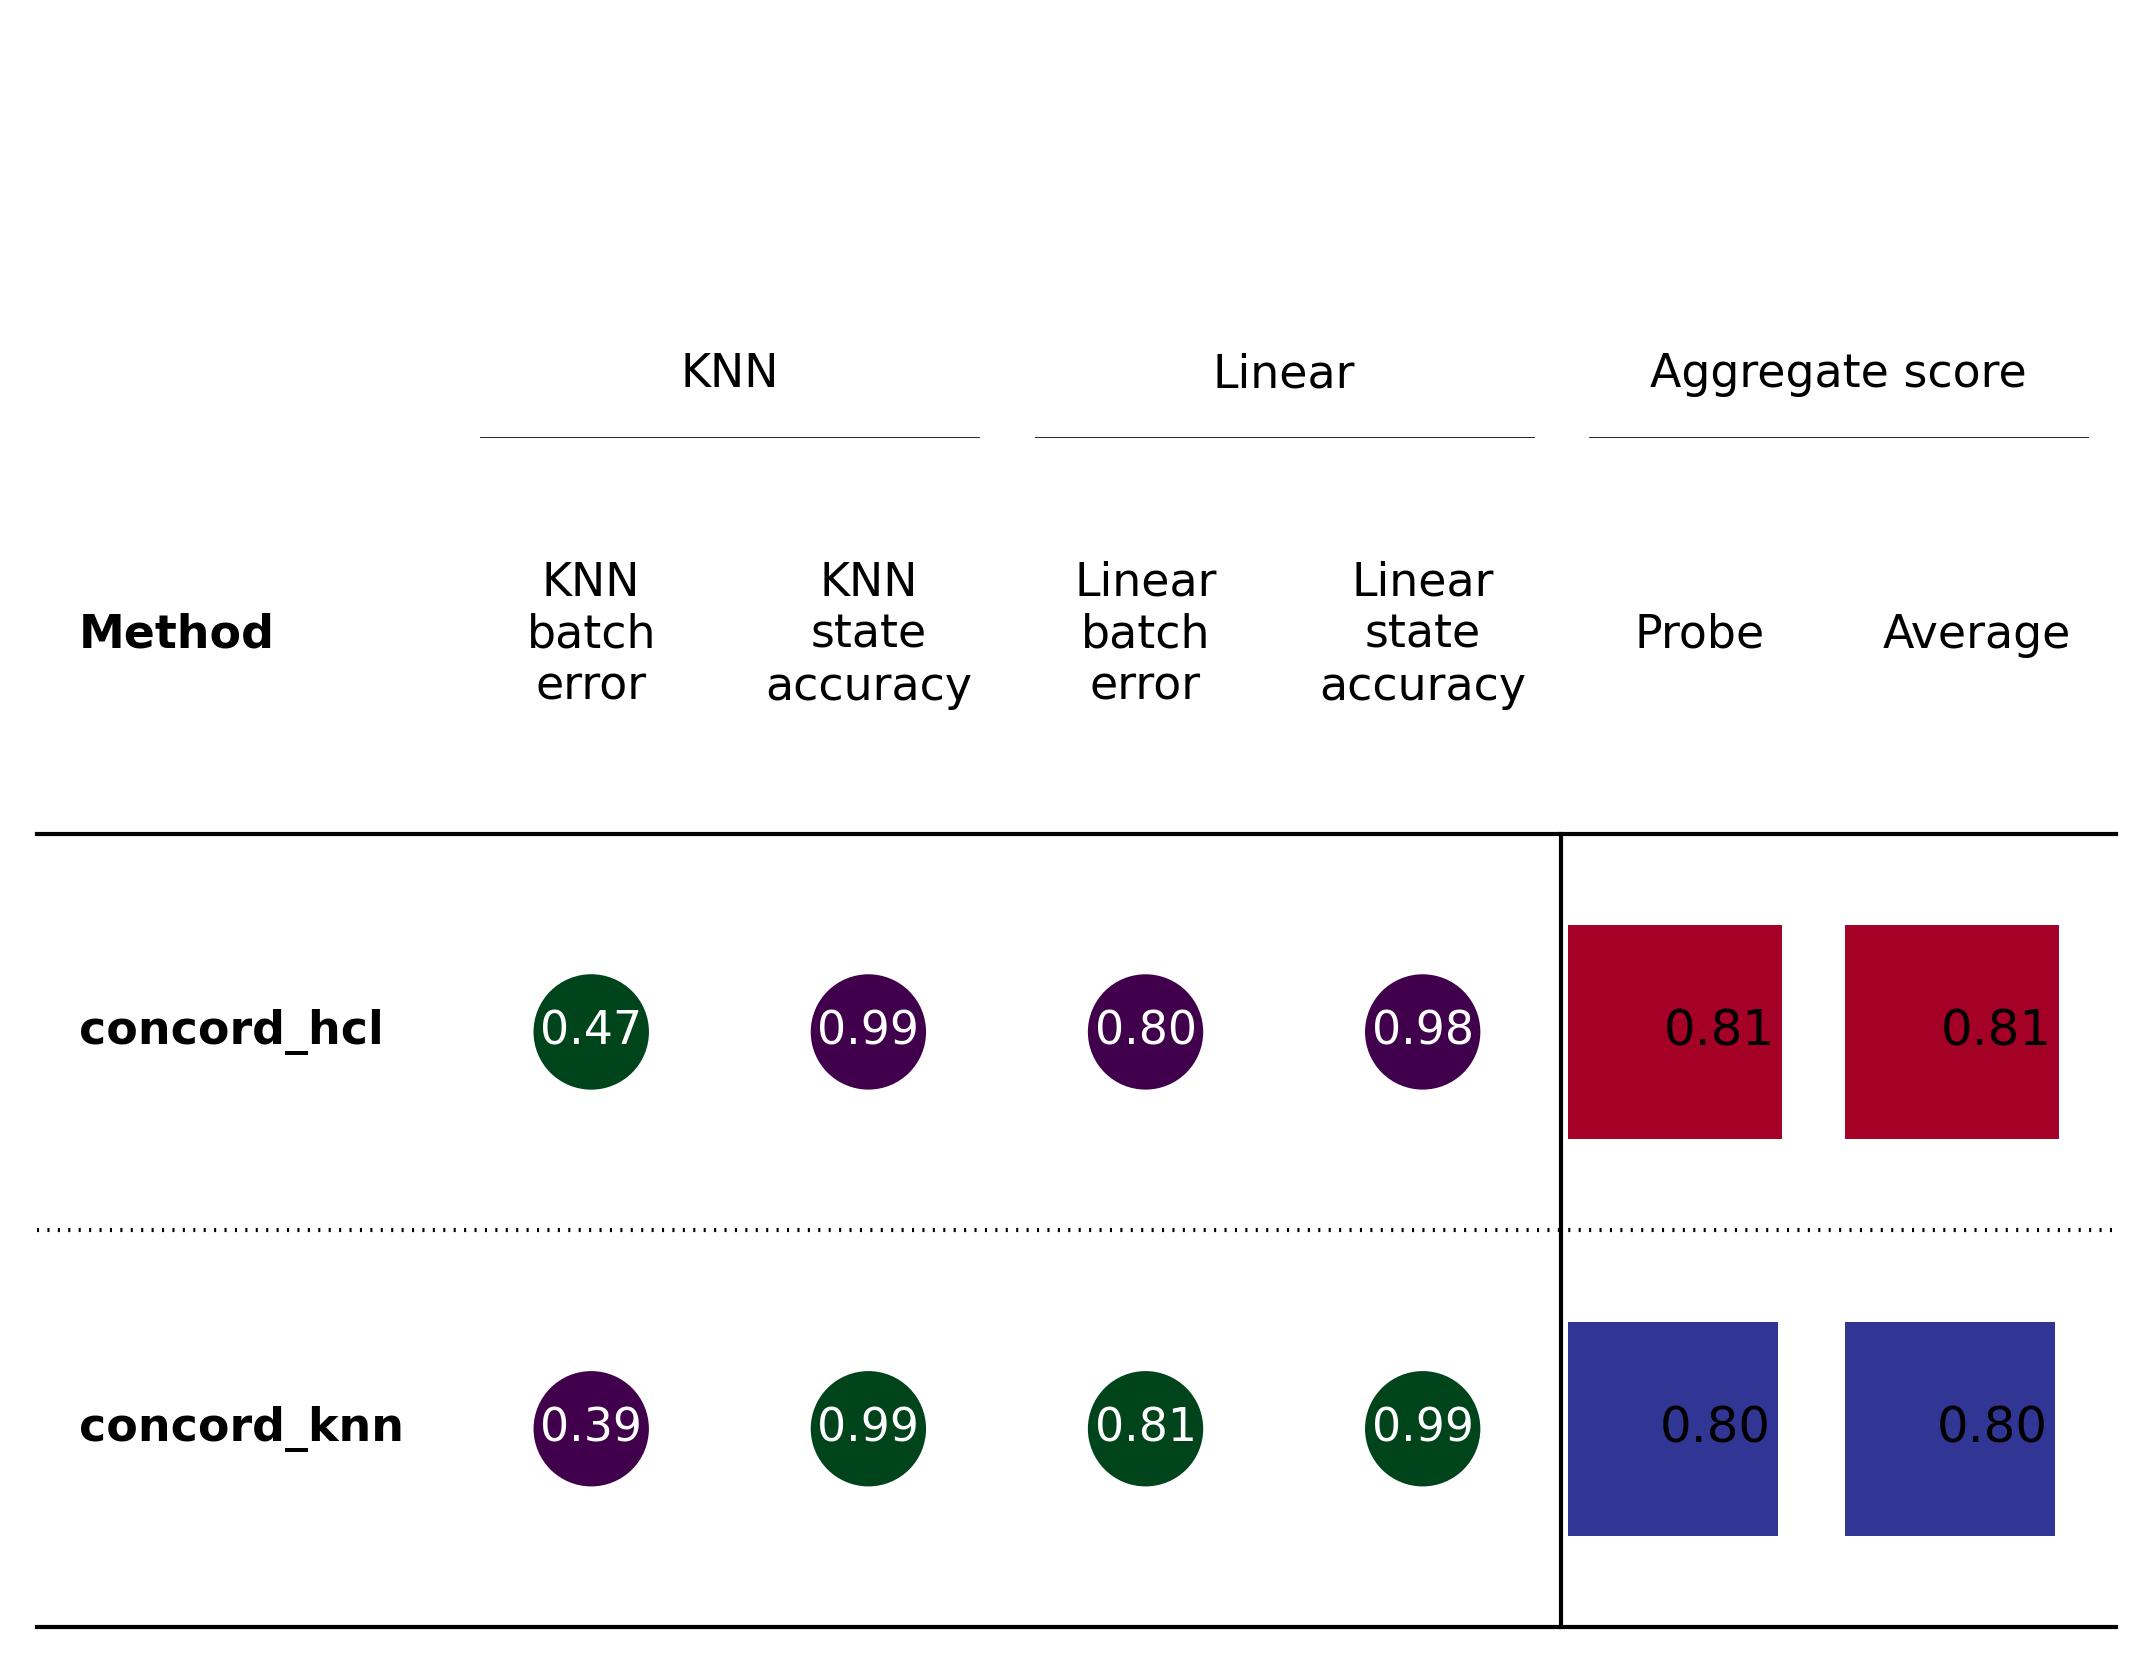

✅ Benchmark results saved to: ../save/hypomap_QZ/benchmark_cell_type_Jul02-1432.pkl


In [21]:
state_key = 'cell_type'
batch_key = 'Batch_ID'
out = ccd.bm.run_benchmark_pipeline(
    adata,
    embedding_keys=py_methods,
    state_key=state_key,
    batch_key=batch_key,
    save_dir=save_dir / "benchmarks_celltype",
    file_suffix=file_suffix,  # e.g. "2025-06-25"
    run=("probe"),          # run only these blocks
    plot_individual=False,          # skip the intermediate PDFs
)
combined_celltype = out["combined"]

# Save the benchmark results
import pickle
with open(save_dir / f"benchmark_{state_key}_{file_suffix}.pkl", "wb") as f:
    pickle.dump(out, f)

print(f"✅ Benchmark results saved to: {save_dir / f'benchmark_{state_key}_{file_suffix}.pkl'}")

In [8]:
out['probe']

KNN                          Linear                  \
             batch\naccuracy state\naccuracy batch\naccuracy state\naccuracy   
Method                                                                         
unintegrated        0.872384        0.927642        0.963114        0.940140   
contrastive         0.631955        0.905181        0.629228        0.901851   
scanorama           0.655309        0.933512        0.479004        0.913976   
scvi                0.528841        0.927514        0.338354        0.932610   
harmony             0.500255        0.936064        0.223740        0.941544   
concord_knn         0.423430        0.906585        0.263816        0.906956   
concord_hcl         0.407989        0.910924        0.258583        0.912317   

                 Probe  
                 Score  
Method                  
unintegrated  0.925820  
contrastive   0.767054  
scanorama     0.745450  
scvi          0.681830  
harmony       0.650401  
concord_knn   0.625197  
concord_hcl   0.622453